# Recurrent Neural Networks

## Univariate Time Series Regression

## Imports

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape
import keras
import keras.backend as K
import tensorflow as tf

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

## Data

In [12]:
data = pd.read_hdf('data.h5', 'returns_weekly')
data = data.drop([c for c in data.columns if str(c).startswith('year')], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1167341 entries, 2009-01-01 to 2017-12-01
Data columns (total 66 columns):
ticker      1167341 non-null int64
1           1167341 non-null float64
2           1167341 non-null float64
3           1167341 non-null float64
4           1167341 non-null float64
5           1167341 non-null float64
6           1167341 non-null float64
7           1167341 non-null float64
8           1167341 non-null float64
9           1167341 non-null float64
10          1167341 non-null float64
11          1167341 non-null float64
12          1167341 non-null float64
13          1167341 non-null float64
14          1167341 non-null float64
15          1167341 non-null float64
16          1167341 non-null float64
17          1167341 non-null float64
18          1167341 non-null float64
19          1167341 non-null float64
20          1167341 non-null float64
21          1167341 non-null float64
22          1167341 non-null float64
23          1167341 non

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

In [13]:
window_size=52
ticker = 1
months = 12
n_tickers = data.ticker.nunique()

In [14]:
train_data = data[:'2016']
test_data = data['2017']
del data

In [15]:
X_train = [
    train_data.loc[:, list(range(1, window_size+1))].values.reshape(-1, window_size , 1),
    train_data.ticker,
    train_data.filter(like='month')
]
y_train = train_data.label
[x.shape for x in X_train], y_train.shape

([(1035424, 52, 1), (1035424,), (1035424, 12)], (1035424,))

In [16]:
# keep the last year for testing
X_test = [
    test_data.loc[:, list(range(1, window_size+1))].values.reshape(-1, window_size , 1),
    test_data.ticker,
    test_data.filter(like='month')
]
y_test = test_data.label
[x.shape for x in X_test], y_test.shape

([(131917, 52, 1), (131917,), (131917, 12)], (131917,))

## Custom Metric

In [17]:
def roc_auc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [18]:
# source: https://github.com/keras-team/keras/issues/3230
def auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true, y_pred, k) for k in np.linspace(0, 1, 1000)], axis=0)
    pfas = tf.stack([binary_PFA(y_true, y_pred, k) for k in np.linspace(0, 1, 1000)], axis=0)
    pfas = tf.concat([tf.ones((1,)), pfas], axis=0)
    binSizes = -(pfas[1:] - pfas[:-1])
    s = ptas * binSizes
    return K.sum(s, axis=0)


def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    """prob false alert for binary classifier"""
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP / (N + 1)


def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    """prob true alerts for binary classifier"""
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP / (P + 1)

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

(given in the cell below).  (remember to copy your completed function into the script *my_answers.py* function titled *build_part1_RNN* before submitting your project)

In [37]:
lstm1_units = 25
lstm2_units = 10
n_features = 1

In [67]:
returns = Input(shape=(window_size, n_features), name='Returns')
tickers = Input(shape=(1,), name='Tickers')
months = Input(shape=(12,), name='Months')

lstm1 = LSTM(units=lstm1_units, 
             input_shape=(window_size, n_features), 
             name='LSTM1', 
             dropout=.2,
             return_sequences=True)(returns)
lstm_model = LSTM(units=lstm2_units, 
             dropout=.2,
             name='LSTM2')(lstm1)


ticker_embedding = Embedding(input_dim=n_tickers, 
                             output_dim=10, 
                             input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(10,))(ticker_embedding)


merged = concatenate([lstm_model, ticker_embedding, months], name='Merged')
hidden_dense = Dense(10, name='FC1')(merged)
output = Dense(1, name='Output')(hidden_dense)

rnn = Model(inputs=[returns, tickers, months], outputs=output)

In [68]:
rnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Returns (InputLayer)            (None, 52, 1)        0                                            
__________________________________________________________________________________________________
Tickers (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 52, 25)       2700        Returns[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        24890       Tickers[0][0]                    
__________________________________________________________________________________________________
LSTM2 (LST

## Train the Model

In [40]:
rnn.compile(loss='binary_crossentropy', 
            optimizer='adam',
           metrics=['accuracy', auc])

In [41]:
rnn_path = 'models/quandl.lstm_months_{}_{}.weights.best.hdf5'.format(lstm1_units, lstm2_units)
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5,
                              restore_best_weights=True)

In [43]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=50,
                 batch_size=32,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpointer, early_stopping],
                 verbose=1)

Train on 1035424 samples, validate on 131917 samples
Epoch 1/50
1035424/1035424 [==============================] - 3494s 3ms/step - loss: 0.6919 - acc: 0.5351 - auc: 0.5407 - val_loss: 0.6889 - val_acc: 0.5454 - val_auc: 0.5967
Epoch 2/50
1035424/1035424 [==============================] - 3394s 3ms/step - loss: 0.6864 - acc: 0.5465 - auc: 0.5549 - val_loss: 0.6777 - val_acc: 0.5713 - val_auc: 0.6060
Epoch 3/50
1035424/1035424 [==============================] - 3418s 3ms/step - loss: 0.6840 - acc: 0.5521 - auc: 0.5631 - val_loss: 0.6777 - val_acc: 0.5702 - val_auc: 0.6066
Epoch 4/50
1035424/1035424 [==============================] - 3429s 3ms/step - loss: 0.6818 - acc: 0.5566 - auc: 0.5693 - val_loss: 0.6826 - val_acc: 0.5602 - val_auc: 0.6010
Epoch 5/50
1035424/1035424 [==============================] - 3407s 3ms/step - loss: 0.6804 - acc: 0.5588 - auc: 0.5730 - val_loss: 0.6748 - val_acc: 0.5824 - val_auc: 0.6130
Epoch 6/50
1035424/1035424 [==============================] - 3414s 3ms/

In [44]:
loss_history = pd.DataFrame(result.history)
loss_history

,acc,auc,loss,val_acc,val_auc,val_loss
0,0.535078,0.540670,0.691900,0.545411,0.596678,0.688937
1,0.546543,0.554898,0.686432,0.571344,0.606000,0.677704
2,0.552075,0.563076,0.684029,0.570222,0.606561,0.677705
3,0.556607,0.569333,0.681848,0.560231,0.600988,0.682648
4,0.558771,0.572967,0.680395,0.582450,0.613039,0.674850
5,0.561651,0.577575,0.678201,0.583875,0.613637,0.669076
6,0.563291,0.580363,0.677105,0.592600,0.618338,0.663972
7,0.564243,0.582291,0.676229,0.580896,0.611599,0.671445
8,0.566009,0.584416,0.675376,0.586543,0.616895,0.668098
9,0.566996,0.585542,0.674590,0.586748,0.619736,0.670394


In [51]:
def which_metric(m):
    return m.split('_')[-1]

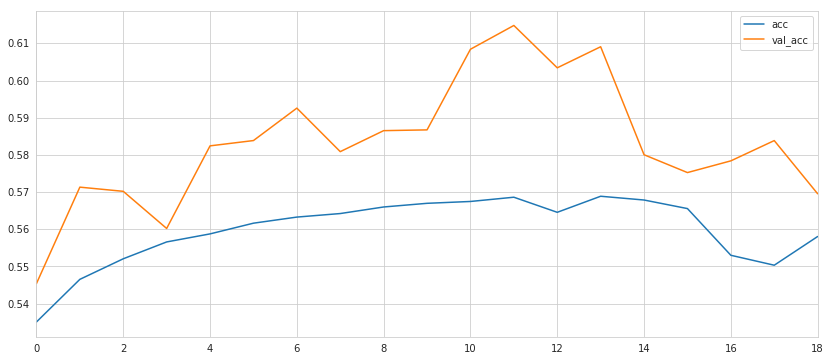

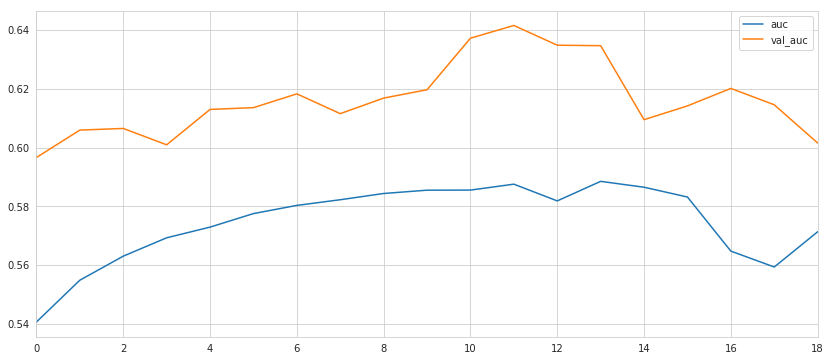

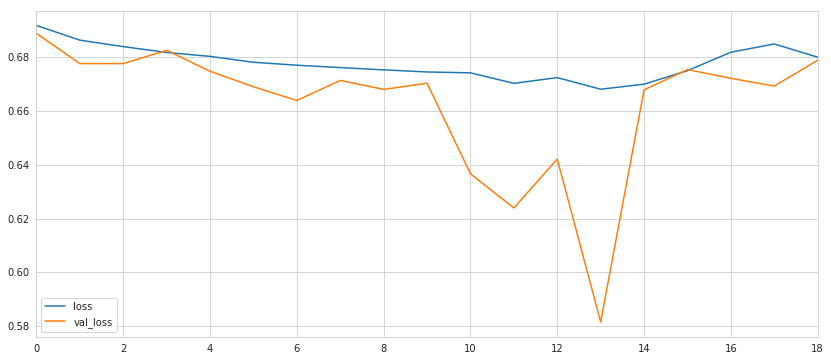

In [59]:
loss_history.groupby(which_metric, axis=1).plot(figsize=(14, 6));

## Evaluate model performance

In [45]:
test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)

In [46]:
roc_auc_score(y_score=test_predict, y_true=y_test)

0.6705719343575394

In [47]:
rnn.load_weights(rnn_path)

In [48]:
test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)

In [49]:
roc_auc_score(y_score=test_predict, y_true=y_test)

0.6316542712390399

In [ ]:
score

In [217]:
predictions = (test_predict.to_frame('prediction').assign(data='test')
               .append(train_predict.to_frame('prediction').assign(data='train')))
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2018-01-02 to 2017-12-29
Data columns (total 2 columns):
prediction    2201 non-null float32
data          2201 non-null object
dtypes: float32(1), object(1)
memory usage: 43.0+ KB


In [219]:
results = sp500_scaled.join(predictions).dropna()
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2010-04-06 to 2018-12-31
Data columns (total 3 columns):
SP500         2201 non-null float64
prediction    2201 non-null float32
data          2201 non-null object
dtypes: float32(1), float64(1), object(1)
memory usage: 60.2+ KB


In [225]:
corr = {}
for run, df in results.groupby('data'):
    corr[run] = df.SP500.corr(df.prediction)

In [266]:
sp500_scaled['Train Prediction'] = pd.Series(train_predict.squeeze(), index=y_train.index)
sp500_scaled['Test Prediction'] = pd.Series(test_predict.squeeze(), index=y_test.index)

In [268]:
training_error = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
testing_error = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print('Training Error: {:.4f} | Test Error: {:.4f}'.format(training_error, testing_error))

Training Error: 0.0078 | Test Error: 0.0150


In [285]:
sns.set_style('whitegrid')